# Set up environment

In [ ]:
!pip install --upgrade pip
!pip install --upgrade plotly
!pip install scikit-learn-intelex

# Libraries

In [3]:
import sys
import os
import site
sys.path.append(os.path.join(os.path.dirname(site.getsitepackages()[0]), "site-packages"))

In [4]:
from sklearnex import patch_sklearn
import numpy as np
patch_sklearn()
from sklearn import svm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.datasets import load_files
# import HOG
from skimage.feature import hog
# img
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from skimage.color import rgb2gray

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [55]:
from sklearn.metrics import confusion_matrix
from skimage import feature
from sklearn.metrics import classification_report 
from sklearn.metrics import plot_confusion_matrix
from timeit import default_timer as timer
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score

In [6]:
from google.colab import files

# Para la descarga del dataset

In [ ]:
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list -s image
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip intel-image-classification.zip
!cp -r seg_pred/seg_pred/* seg_pred/
!rm -rf seg_pred/seg_pred
!cp -r seg_test/seg_test/* seg_test/
!rm -rf seg_test/seg_test/
!cp -r seg_train/seg_train/* seg_train/
!rm -rf seg_train/seg_train/

# Datos

## Lectura de los directorios

In [9]:
train_dir='./seg_train'
test_dir='./seg_test'

def load_dataset(path):
  data = load_files(path)
  files = np.array(data['filenames'])
  targets = np.array(data['target'])
  target_labels = np.array(data['target_names'])
  return files, targets, target_labels

x_train_l, y_train, target_labels = load_dataset(train_dir)
x_test_l, y_test, _ = load_dataset(test_dir)
print('Loading complete!')

Loading complete!


# Confirmacion

In [10]:
print(target_labels)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


In [ ]:
# # makes y categorial, doesn't work on SVM
# from keras.utils import np_utils
# y_train = np_utils.to_categorical(y_train,no_of_classes)
# y_test = np_utils.to_categorical(y_test,no_of_classes)
# y_train[0] # Note that only one element has value 1(corresponding to its label) and others are 0.

In [11]:
print(len(x_train_l))  #14008
print(len(x_test_l))  # 3000

14034
3000


In [12]:
t=len(x_train_l)+len(x_test_l)
print(len(x_train_l)/t)
print(len(x_test_l)/t)

0.8238816484677703
0.17611835153222966


# Imagenes en arreglos, a escale de grises

In [13]:
"""
Funcion paara leer el path de la imagen y convertirlo en un array 2d de un solo
canal, es decir escala de grises
"""
def convert_image_to_array(files, color_mode='grayscale'):
  images_as_array=None
  img_sz=150
  if color_mode=='grayscale':
    images_as_array=np.zeros((len(files),img_sz,img_sz))
  elif color_mode=='rgb':
    images_as_array=np.zeros((len(files),img_sz,img_sz,3))

  # for file in files:
  for ix,file in enumerate(files):
    # Convert to Numpy Array
    img = load_img(file,target_size=(img_sz,img_sz),color_mode=color_mode)
    img = img_to_array(img) 
    if color_mode == 'grayscale':
      img = img.reshape(img.shape[0],-1)
    # images_as_array.append(img)
    # images_as_array = np.vstack([images_as_array, img])
    images_as_array[ix]=img
    # images_as_array.(img)
  return images_as_array

In [14]:
%%time
x_train = convert_image_to_array(x_train_l)
print('Training set shape : ',x_train.shape)

x_test = convert_image_to_array(x_test_l)
print('Test set shape : ',x_test.shape)

# CANT RUN RGB on COLAB NEED MORE THAN 12GB RAM

Training set shape :  (14034, 150, 150)
Test set shape :  (3000, 150, 150)
CPU times: user 14.6 s, sys: 2.05 s, total: 16.6 s
Wall time: 16.7 s


In [15]:
# Image dimensions
print(x_train[0].shape)

(150, 150)


In [16]:
# Mostrar imagen
fig=px.imshow(x_train[0])
fig.show()

(150, 150)
(150,)
()


# SVM

## LBP, HOG

In [17]:
"""
Funcion para es uso de Local Binary pattern
"""
def LBP(image, numPoints, radius, eps=1e-7):
	lbp = feature.local_binary_pattern(image, numPoints, radius, method="uniform")
	(hist, _) = np.histogram(
     lbp.ravel(),
     bins=np.arange(0, numPoints + 3),
     range=(0, numPoints + 2))
	# normalize the histogram
	hist = hist.astype("float")
	hist /= (hist.sum() + eps)
	# return the histogram of Local Binary Patterns
	return hist

In [75]:
"""
Funciones auxiliares para el uso de LBP y HOG.
"""
def lbp_desc(imgs, points, radius):
  _shape = imgs.shape
  imgs_desc = np.zeros((_shape[0],points+2))
  for ix, _img in enumerate(imgs):
    imgs_desc[ix] = LBP(_img, points, radius)
  return imgs_desc

def hog_desc(imgs):
  _shape = imgs.shape
  # 3969 bw
  feature_list = np.zeros((_shape[0],3969))
  for ix,_img in enumerate(imgs):
    feature_list[ix]=hog(_img, block_norm='L2-Hys', pixels_per_cell=(16,16))
  return feature_list

In [51]:
%%time
# lbp
x_train_lbp = lbp_desc(x_train,24,3)
x_test_lbp =lbp_desc(x_test,24,3)

CPU times: user 2min 50s, sys: 108 ms, total: 2min 50s
Wall time: 2min 50s


In [53]:
# hog
x_train_hog = hog_desc(x_train)
x_test_hog = hog_desc(x_test)

# Entrenamiento

In [61]:
params = {
    'kernel': ['rbf','linear'],
}
svm_clf_hog = GridSearchCV(svm.SVC(random_state=0), params, cv=5)
svm_clf_hog.fit(x_train_hog, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=0, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'kernel': ['rbf', 'linear']}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

In [71]:
params_ = {
    'C': [1,10],
    'kernel': ['rbf','linear'],
    'gamma': [0.1,1,10]
}
svm_clf_lbp = GridSearchCV(svm.SVC(random_state=0), params_, cv=5)
svm_clf_lbp.fit(x_train_lbp, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=0, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10], 'gamma': [0.1, 1, 10],
                         'kernel': ['rbf', 'linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

# Resultados

In [62]:
predicted = dict()

In [72]:
predicted['svm-hog'] = svm_clf_hog.predict(x_test_hog)
predicted['svm-lbp'] = svm_clf_lbp.predict(x_test_lbp)

for name, model in predicted.items():
  print('Classification Report for {0}:\n {1}'.format(
        name,
        classification_report(y_test, predicted[name])))

Classification Report for svm-hog:
               precision    recall  f1-score   support

           0       0.84      0.82      0.83       437
           1       0.89      0.93      0.91       474
           2       0.67      0.72      0.69       553
           3       0.66      0.66      0.66       525
           4       0.80      0.74      0.77       510
           5       0.87      0.83      0.85       501

    accuracy                           0.78      3000
   macro avg       0.79      0.79      0.79      3000
weighted avg       0.78      0.78      0.78      3000

Classification Report for svm-lbp:
               precision    recall  f1-score   support

           0       0.60      0.44      0.51       437
           1       0.73      0.89      0.80       474
           2       0.49      0.51      0.50       553
           3       0.51      0.55      0.53       525
           4       0.63      0.44      0.52       510
           5       0.56      0.66      0.60       501

    a

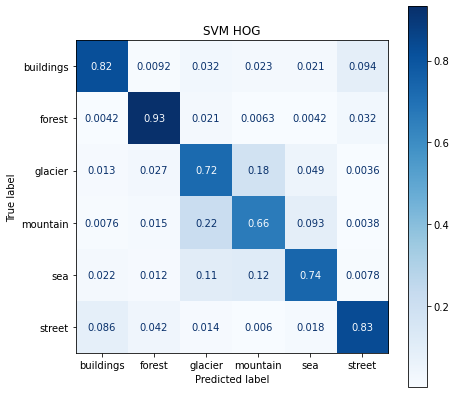

In [66]:
disp = plot_confusion_matrix(
    svm_clf_hog, 
    x_test_hog, 
    y_test,
    display_labels=target_labels, 
    normalize='true',
    cmap=plt.cm.Blues)
disp.ax_.set_title('SVM HOG')
disp.figure_.set_size_inches(7,7)
plt.show()

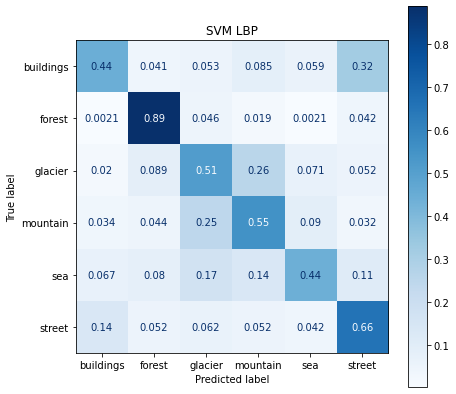

In [73]:
disp = plot_confusion_matrix(
    svm_clf_lbp, 
    x_test_lbp, 
    y_test,
    display_labels=target_labels, 
    normalize='true',
    cmap=plt.cm.Blues)
disp.ax_.set_title('SVM LBP')
disp.figure_.set_size_inches(7,7)
plt.show()

In [69]:
print("SVM HOG")
print("Best score: {0}, Best params: {1}".format(
    svm_clf_hog.best_score_, svm_clf_hog.best_params_))
means = svm_clf_hog.cv_results_['mean_test_score']
parameters = svm_clf_hog.cv_results_['params']
for _mean,_param in zip(means, parameters):
  print(_mean, _param)

Best score: 0.7677068656126713, Best params: {'kernel': 'rbf'}
0.7677068656126713 {'kernel': 'rbf'}
0.7013681558246732 {'kernel': 'linear'}


In [74]:
print("SVM LBP")
print("Best score: {0}, Best params: {1}".format(
    svm_clf_lbp.best_score_, svm_clf_lbp.best_params_))
means = svm_clf_lbp.cv_results_['mean_test_score']
parameters = svm_clf_lbp.cv_results_['params']
for _mean,_param in zip(means, parameters):
  print(_mean, _param)

SVM LBP
Best score: 0.5884284299941521, Best params: {'C': 10, 'gamma': 10, 'kernel': 'rbf'}
0.32392796138154767 {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.388057907364772 {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}
0.41520618065872894 {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.388057907364772 {'C': 1, 'gamma': 1, 'kernel': 'linear'}
0.5195245772139246 {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
0.388057907364772 {'C': 1, 'gamma': 10, 'kernel': 'linear'}
0.41513503178211686 {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.4940146071030549 {'C': 10, 'gamma': 0.1, 'kernel': 'linear'}
0.5246551932966688 {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.4940146071030549 {'C': 10, 'gamma': 1, 'kernel': 'linear'}
0.5884284299941521 {'C': 10, 'gamma': 10, 'kernel': 'rbf'}
0.4940146071030549 {'C': 10, 'gamma': 10, 'kernel': 'linear'}
